Here, we try running the trajectory analysis on a [Diffusion Map](https://doi.org/10.1093/bioinformatics/btv325) embedding rather than a UMAP embedding of the data

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(monocle3, quietly = T)
    library(SeuratWrappers, quietly = T)
    
    library(ggplot2, quietly = T)
    library(cowplot, quietly = T)
    
    library(dplyr, quietly = T)
    
    library(destiny)
})

In [2]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
}

Associated tutorials:

1) https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/
2) http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/monocle3.html
3) https://stuartlab.org/signac/articles/monocle.html

In [3]:
# Load and format T cell data to get just the CD8s

In [4]:
abc.tcells<-readRDS(paste0(data_path, 'processed/abc_tcells.RDS'))
Idents(abc.tcells)<-'Cell.Type.Level2'

Subset to just the CD8+ T cells

In [5]:
abc.cd8s.all<-abc.tcells[, unname(sapply(as.character(abc.tcells$Cell.Type.Level2), function(x) startsWith(x, 'CD8+')))]

Run diffusion map on number of PCs determined in [Transformation notebook](./01_process_data/01A_Transform.ipynb).

Directly replace UMAP embedding with DiffusionMap to avoid issues with monocle not handling diffusion map.

In [10]:
n_pcs<-44
abc.cds.all.sc<-Seurat::as.SingleCellExperiment(abc.cd8s.all)

# filter for n_pcs
reducedDims(abc.cds.all.sc)[['PCA']]<-reducedDims(abc.cds.all.sc)[['PCA']][, 1:n_pcs]
reducedDims(abc.cds.all.sc)[['pca']]<-reducedDims(abc.cds.all.sc)[['PCA']]

dm <- destiny::DiffusionMap(data = abc.cds.all.sc, 
                     n_pcs = n_pcs) # uses PCs in abc.cds.all by default

abc.cd8s.all@reductions$umap<-NULL
abc.cd8s.all[['umap']] <-  CreateDimReducObject(embeddings = dm@eigenvectors, 
                                                        key = "UMAP_", 
                                                        assay = DefaultAssay(abc.cd8s.all))

Warning message:
“as(<dsCMatrix>, "dsTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead”


Unlike in UMAP space, the distince naive T-cell clusters 30, 41 and 43 all group together in DiffusionMap space. Thus, we do not need to worry about setting the root node based on just one of the clusters:

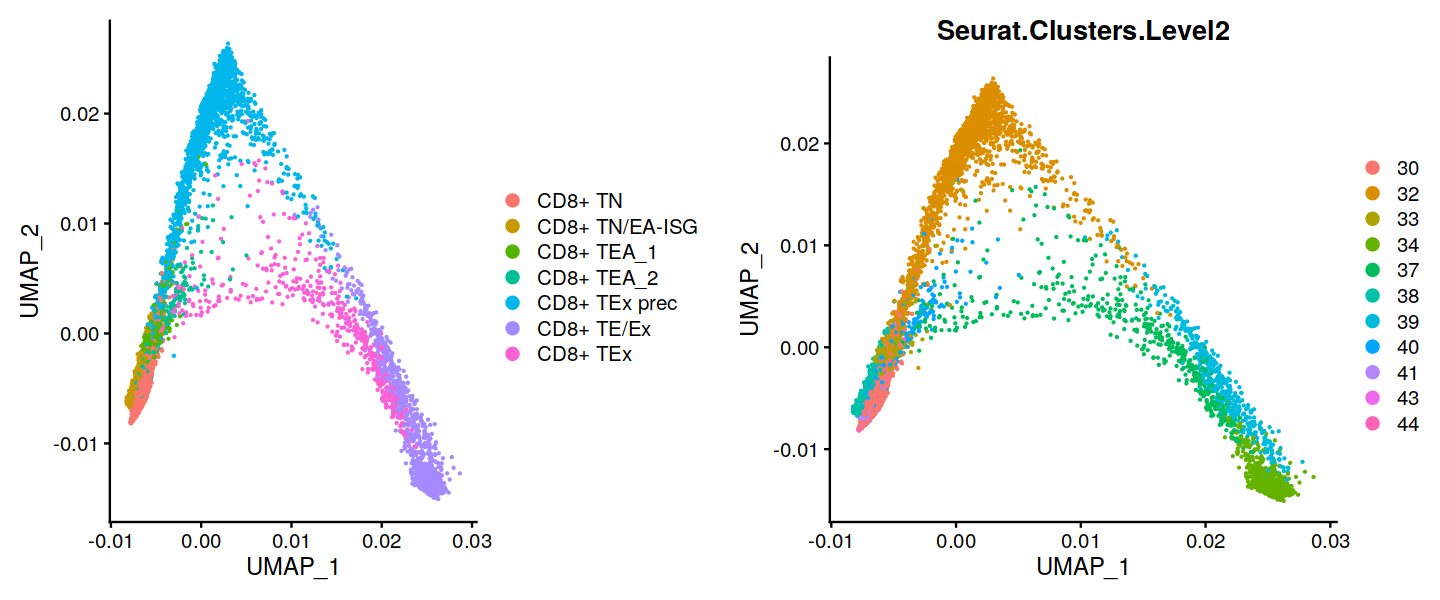

In [11]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all, reduction = 'umap', shuffle = T)
g1B<-DimPlot(abc.cd8s.all, reduction = 'umap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1<-cowplot::plot_grid(g1A, g1B, ncol = 2)
g1

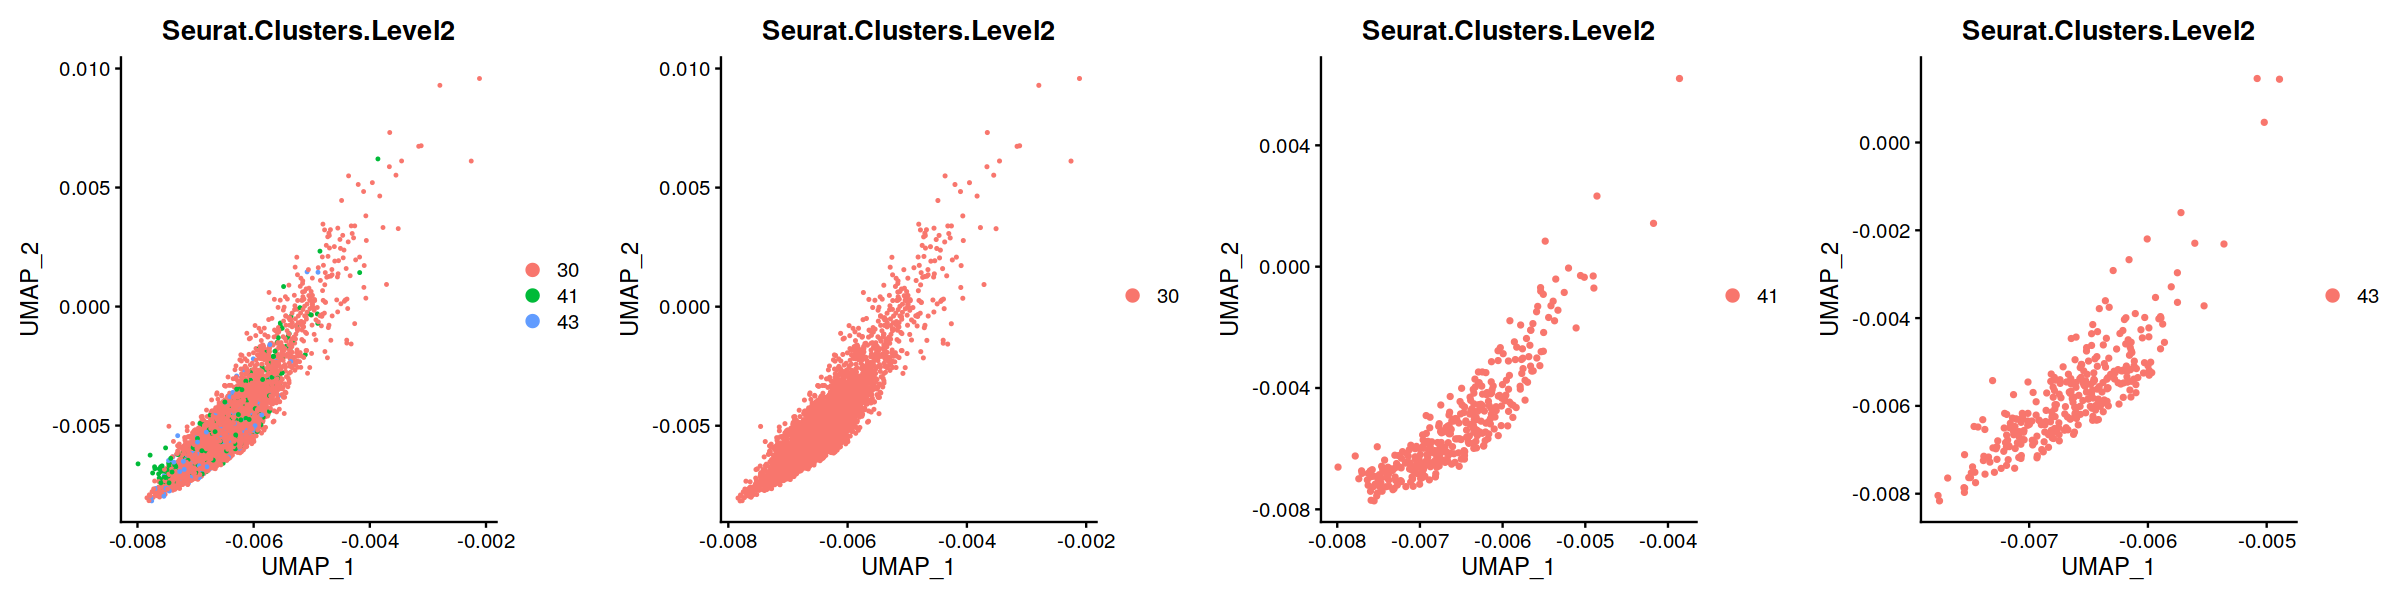

In [12]:
naives.only<-subset(abc.cd8s.all, subset = Seurat.Clusters.Level2 %in% c('30', '41', '43'))

h_ = 5
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(naives.only, reduction = 'umap', shuffle = T)
g1B<-DimPlot(naives.only, reduction = 'umap', group.by = 'Seurat.Clusters.Level2', shuffle = T)

g1C<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('30')), 
             reduction = 'umap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1D<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('41')), 
             reduction = 'umap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1E<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('43')), 
             reduction = 'umap', group.by = 'Seurat.Clusters.Level2', shuffle = T)

g1<-cowplot::plot_grid(g1B, g1C, g1D, g1E, ncol = 4)
g1

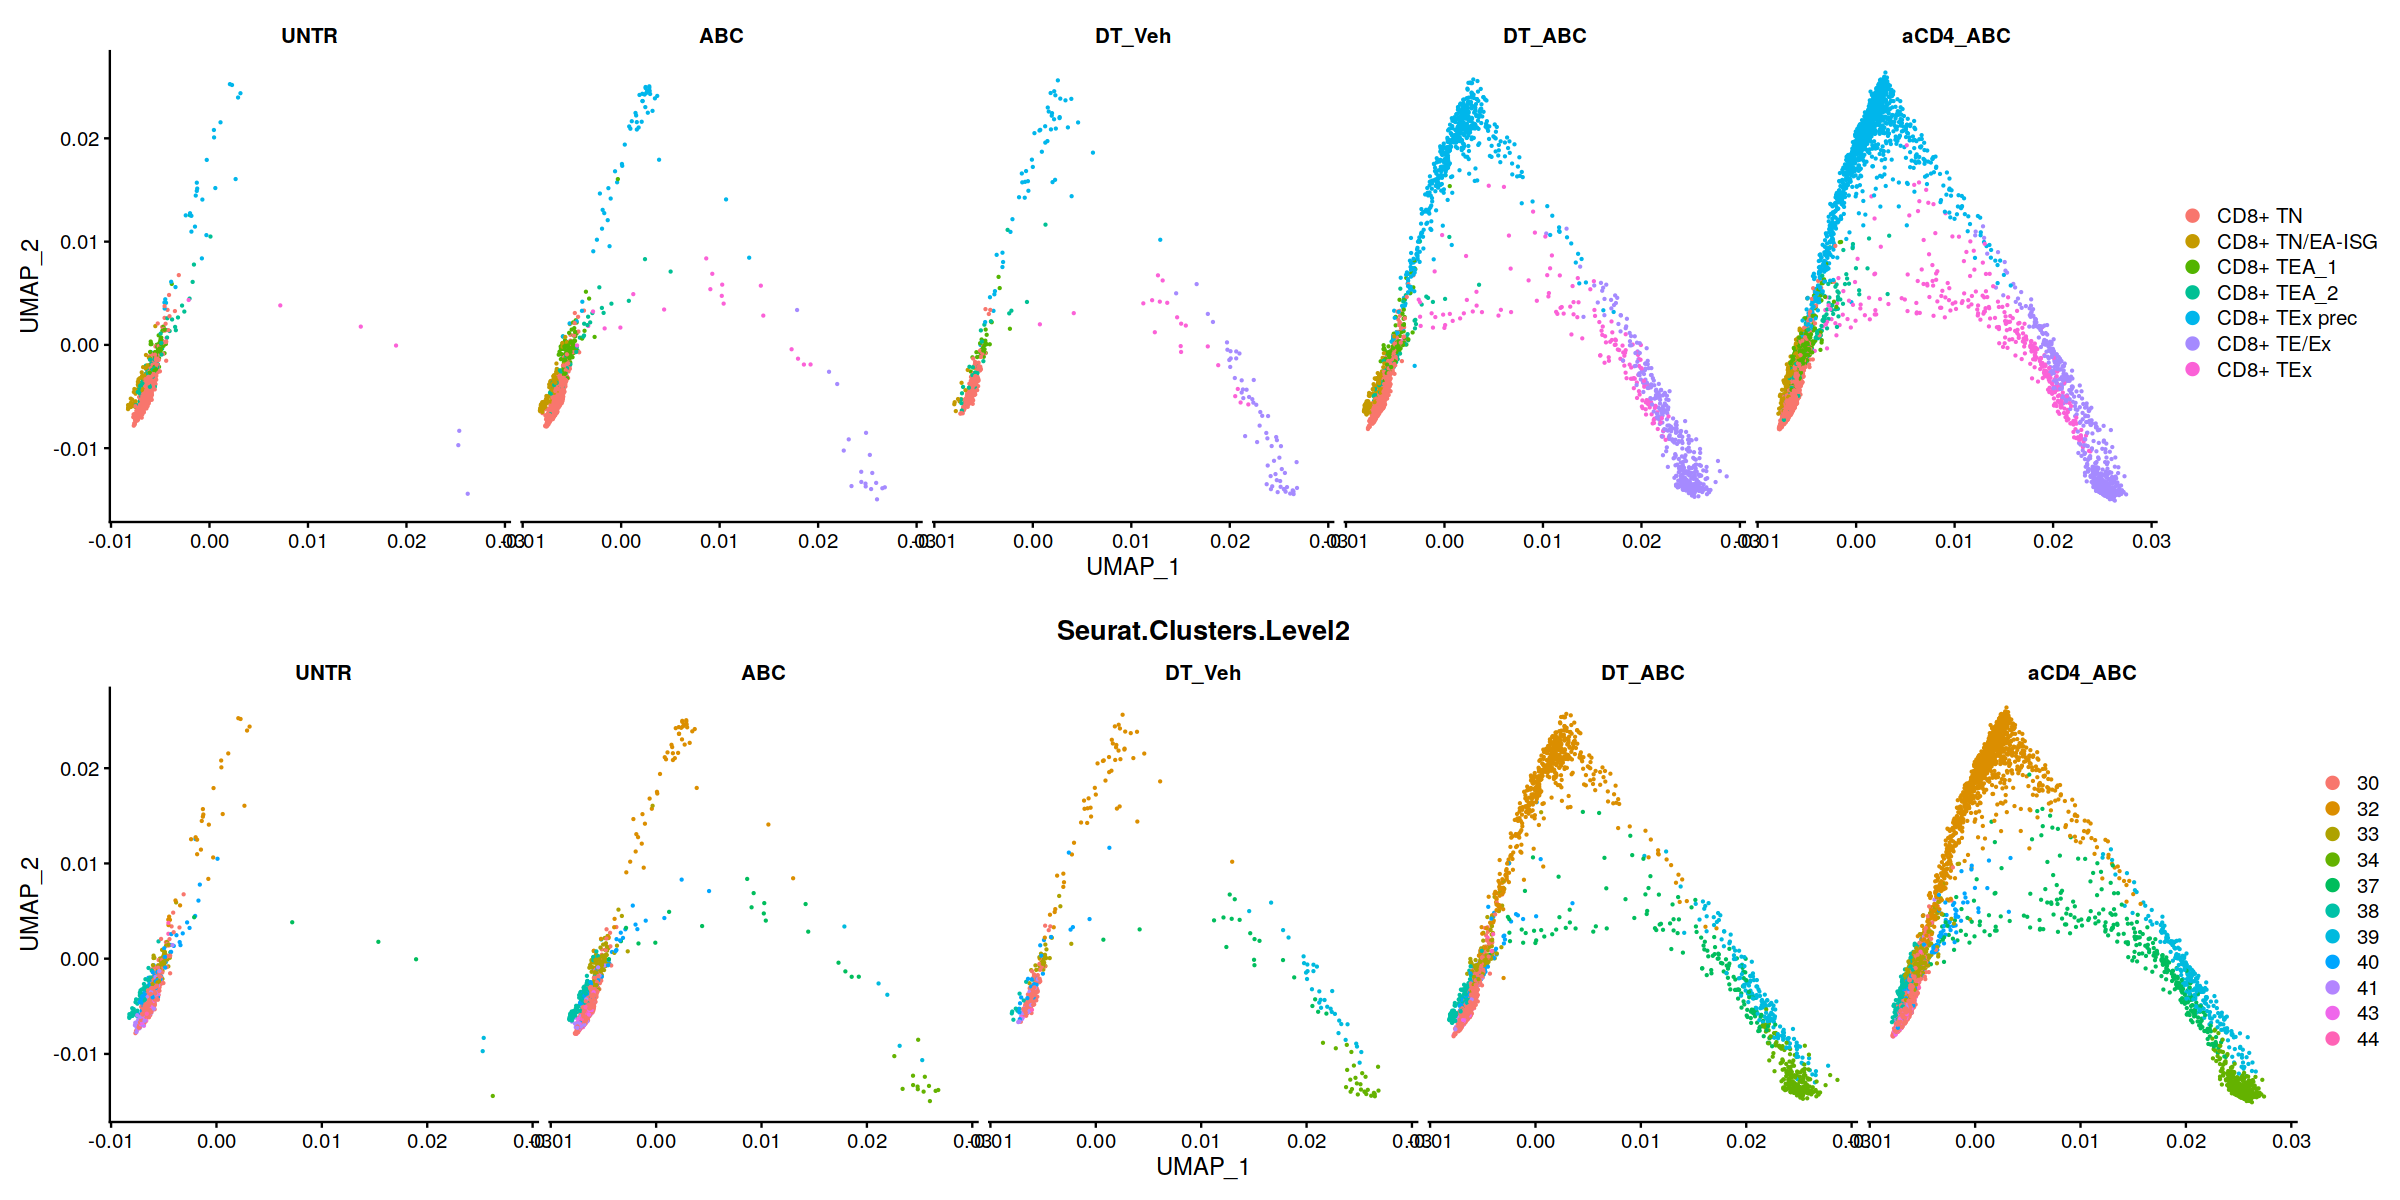

In [13]:
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2A<-DimPlot(abc.cd8s.all, reduction = 'umap', split.by = 'orig.ident')
g2B<-DimPlot(abc.cd8s.all, reduction = 'umap', group.by = 'Seurat.Clusters.Level2', split.by = 'orig.ident')
g2<-cowplot::plot_grid(g2A, g2B, ncol = 1)
g2

In [14]:
md<-abc.cd8s.all@meta.data

md[['Root.Node']]<-'no'
md[(md$Cell.Type.Level2 == 'CD8+ TN'), 'Root.Node']<-'yes'
# md[(md$Cell.Type.Level2 == 'CD8+ TN') & (md$Seurat.Clusters.Level2 != '44'), 'Root.Node']<-'yes'
abc.cd8s.all@meta.data<-md

In [15]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, root.node="yes", dr = 'UMAP'){
  cell_ids <- which(colData(cds)[, "Root.Node"] == root.node)
  
  closest_vertex <-
  cds@principal_graph_aux[[dr]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[[dr]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

In [16]:
abc.cd8s.so<-Seurat::SplitObject(abc.cd8s.all, split.by = 'orig.ident')

# Version 1: Split into each context:

Do the trajectory analysis:

calculate trajectory on each condition separately

<span style="color:red">**Note, this does not set the same root across conditions**, but for each condition, it does the following as specified by the Monocle [tutorial](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/):

>It's often desirable to specify the root of the trajectory programmatically, rather than manually picking it. The function below does so by first grouping the cells according to which trajectory graph node they are nearest to. Then, it calculates what fraction of the cells at each node come from the earliest time point. Then it picks the node that is most heavily occupied by early cells and returns that as the root.

<span style="color:red">Techically, it would not be possible to set the same root since the trajectory is calculated separately on each context, but an alternative option we could try is to find the node  in each context that is closest to the one that would be set if we did it for all contexts together.

In [40]:
# abc.cd8s <- lapply(X = abc.cd8s.so, FUN = function(x){
#     x<-SeuratWrappers::as.cell_data_set(x)
#     x<-monocle3::cluster_cells(cds = x)
#     x<-monocle3::learn_graph(cds = x)#, use_partition = F) 

# #     cd8_tn<-rownames(colData(x)[x$Cell.Type.Level2 == 'CD8+ TN', ])
# #     x<-monocle3::order_cells(x, root_cells = cd8_tn) # get trajectory with CD8 TN as root
#     x <- order_cells(x, root_pr_nodes=get_earliest_principal_node(x))
# })

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [41]:
# traj.plots<-list()
# for (i in seq_along(abc.cd8s)){

#     g1<-DimPlot(abc.cd8s.so[[i]]) + ggtitle(paste0('Condition: ', names(abc.cd8s)[[i]]))
    
# #     if (i != length(abc.cd8s)){
# #         g1<-g1 + theme(legend.position="none")
# #     }
    
#     g2<-plot_cells(cds = abc.cd8s[[i]], color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
#                    trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
#                    graph_label_size = 3,
#               label_cell_groups=FALSE, label_roots = TRUE,
#                label_leaves=TRUE,
#                label_branch_points=TRUE)
#     g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
#     traj.plots[[names(abc.cd8s)[[i]]]]<-g
# }

white circles are roots, gray circles are leaves, blue circles are branch points:

In [55]:
# h_ = 12
# w_ = 35
# options(repr.plot.height=h_, repr.plot.width=w_)

# g1<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

# for (ext in c('.svg', '.png', '.pdf')){
#     fn<-paste0(data_path, 'figures/', 'cd8_trajectory_separate', ext)
#     ggsave(fn, g1, height = h_, width = w_)}

# g1

# Version 2
Repeat the same thing, but run trajectory analysis on all samples simultaneously rather than each one separately:

In [29]:
abc.cd8s.all.cds<-SeuratWrappers::as.cell_data_set(abc.cd8s.all)
abc.cd8s.all.cds<-monocle3::cluster_cells(cds = abc.cd8s.all.cds)
abc.cd8s.all.cds<-monocle3::learn_graph(cds = abc.cd8s.all.cds)
abc.cd8s.all.cds <- monocle3::order_cells(abc.cd8s.all.cds, 
                                reduction_method = 'UMAP', 
                                root_pr_nodes=get_earliest_principal_node(abc.cd8s.all.cds))

  |======================================================================| 100%


<font color='red'>Need to fix this trajectory plot. Looks like something is going wrong with the learn_graph function</font> 

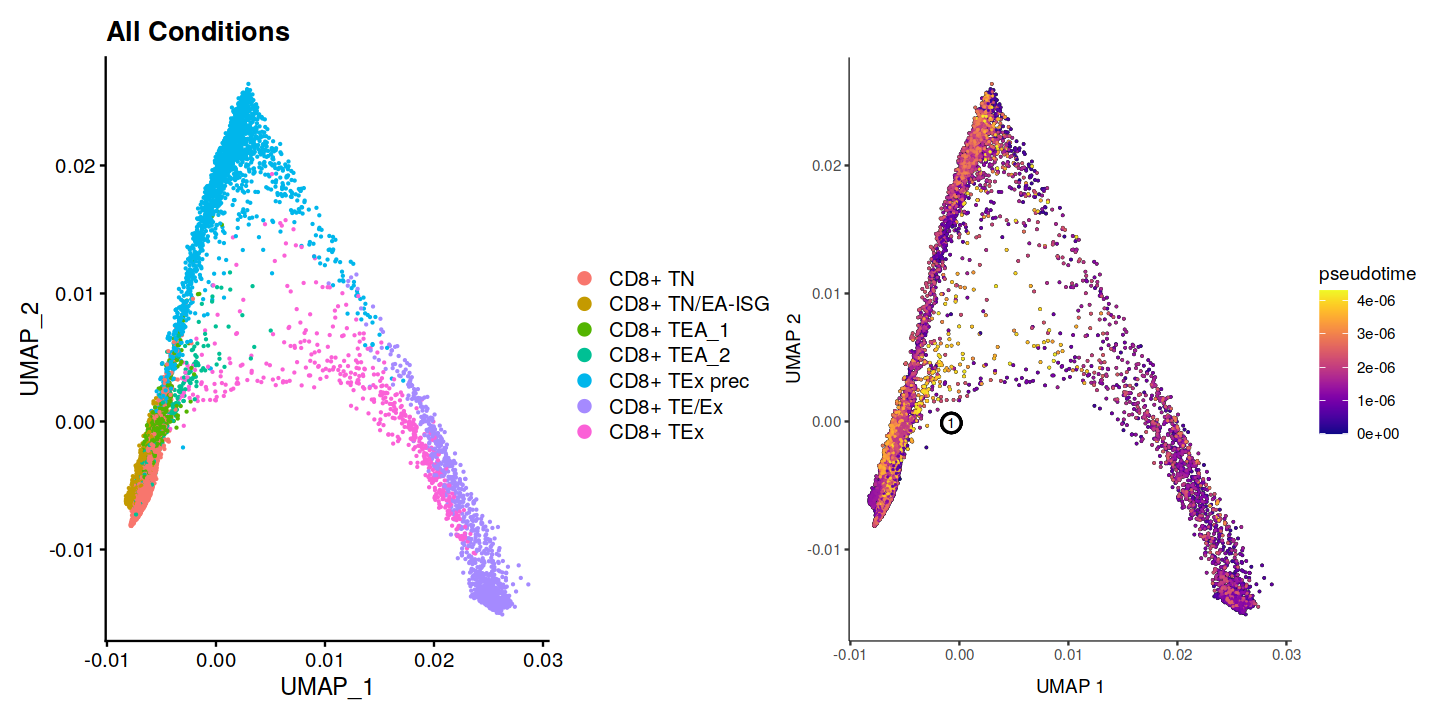

In [30]:
h_ = 6
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all, reduction = 'umap') + ggtitle('All Conditions')
g1B<-plot_cells(cds = abc.cd8s.all.cds, 
                reduction_method = 'UMAP',
                color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
                   graph_label_size = 3,
              label_cell_groups=FALSE, label_roots = TRUE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
g1<-g1A+g1B

# for (ext in c('.svg', '.png', '.pdf')){
#     fn<-paste0(data_path, 'figures/', 'cd8_trajectory_all', ext)
#     ggsave(fn, g1, height = h_, width = w_)}

g1

In [32]:
traj.plots<-list()
conditions <- unique(abc.cd8s.all.cds$orig.ident)
for (i in seq_along(conditions)){
    g1<-DimPlot(abc.cd8s.so[[i]], reduction = 'umap') + ggtitle(paste0('Condition: ', conditions[[i]]))

    
    g2<-plot_cells(cds = abc.cd8s.all.cds[, abc.cd8s.all.cds$orig.ident == conditions[[i]]], 
                    reduction_method = 'UMAP', 
                   color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
                   graph_label_size = 3,
              label_cell_groups=FALSE, label_roots = TRUE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
    g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
    traj.plots[[conditions[[i]]]]<-g
}

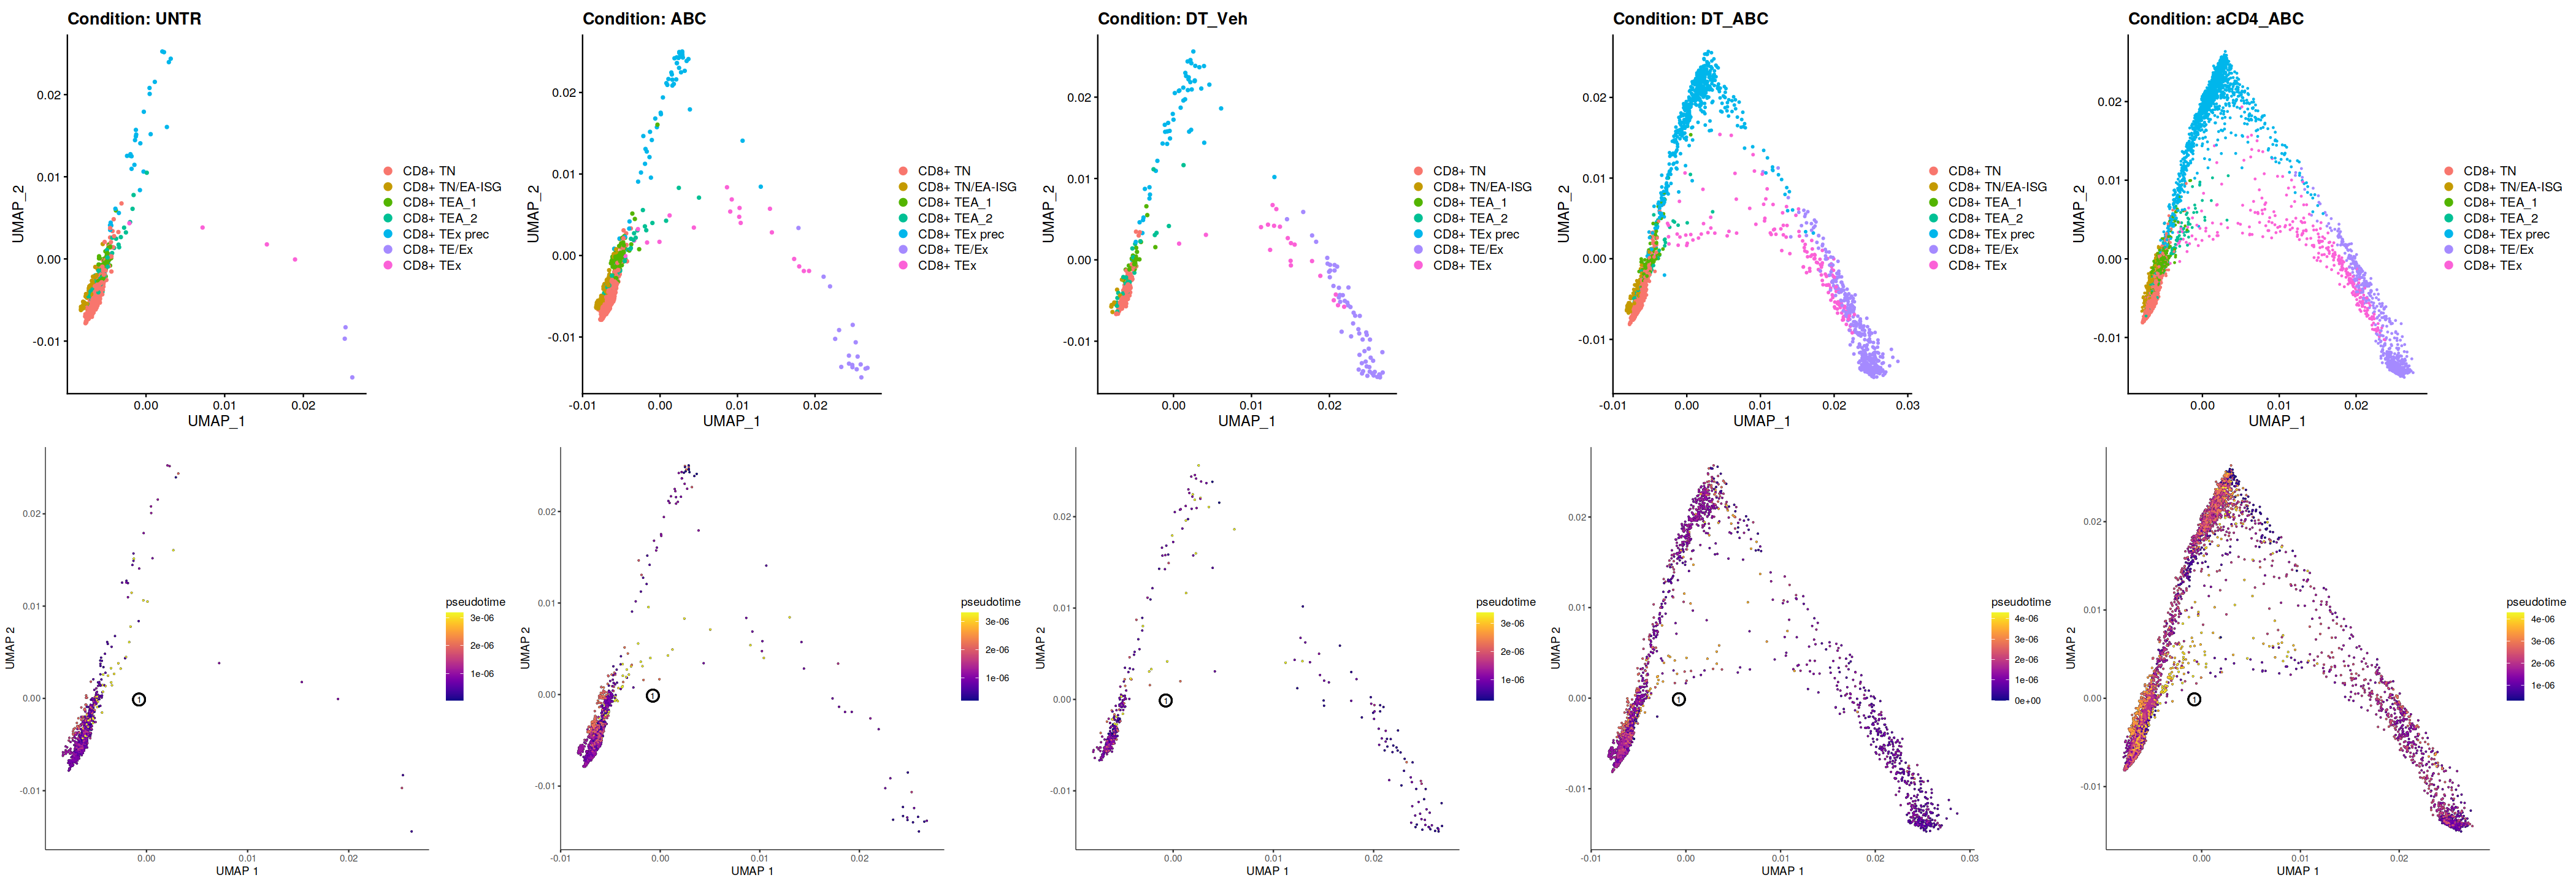

In [33]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g2<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))


g2